## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 11:57:19.165243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 11:57:19.165260: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
data=pd.read_csv('heart.csv')

In [7]:
np.random.seed(42)
data=data.sample(frac=1)

In [8]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/HeartDisease.csv")
data.to_csv(output_file_path, index=False)

In [10]:
data['target'].value_counts()

1    164
0    138
Name: target, dtype: int64

In [11]:
data.drop(['target'],axis=1, inplace=True)

In [12]:
np.random.seed(42)
data=data.sample(frac=1)

### UMAP on entire data

In [13]:
from fdc.fdc import feature_clustering

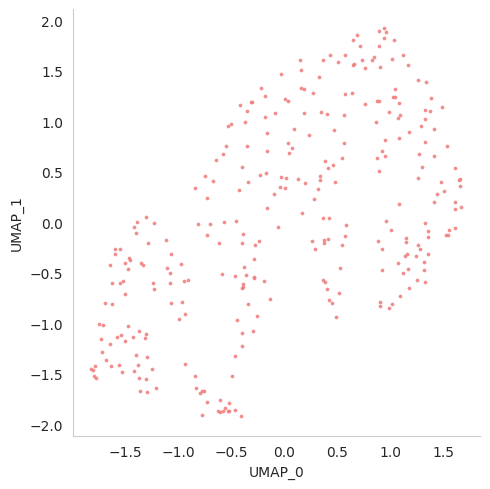

In [14]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [15]:
nom_list=['cp','slope','ca','thal']

ord_list=['sex','fbs','restecg','exang']

cont_list=['age','trestbps', 'chol','thalach','oldpeak']

target = ['target']


In [16]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/HeartDisease.json")

In [17]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 0.98432 / 0.984s


FDC.normalize (clustering ORD): 2.42576 / 3.410s
FDC.normalize (clustering NOM): 0.00006 / 3.410s
FDC.normalize (concat): 0.00002 / 3.410s


FDC.normalize (umap 5 -> 2): 1.08385 / 4.494s
FDC.normalize (array -> DataFrame): 0.00030 / 4.494s


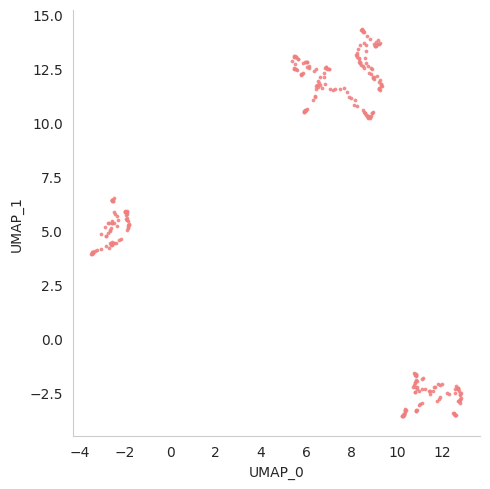

FDC.normalize (plotting): 0.42225 / 4.917s
FDC.normalize (array -> DataFrame): 0.00018 / 4.917s
FDC.normalize (total): 0.00001 / 4.917s


In [18]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

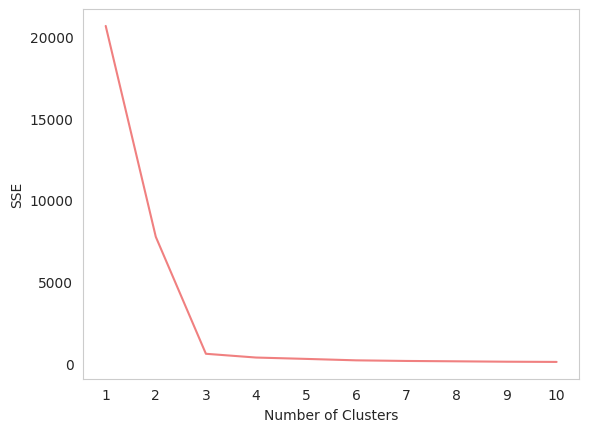

In [19]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [20]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [21]:
find_optimal_cluster(FDC_emb_low)

[0.67583257, 0.8661685, 0.7058021, 0.73181814, 0.623937, 0.541388, 0.5252128]

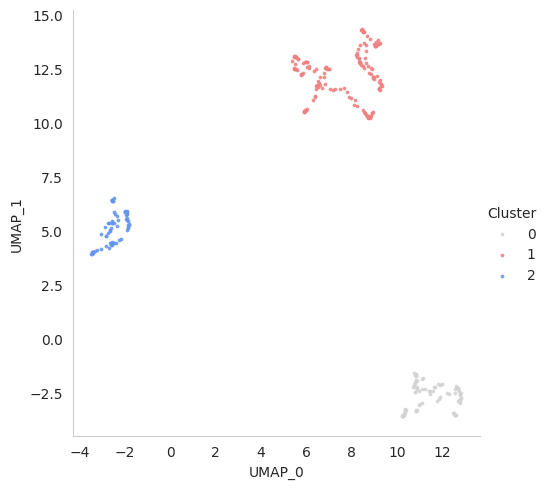

In [22]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

In [23]:
cluster_counts

array([ 86, 147,  69])

In [24]:
data['Target']=cluster_list

In [25]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSHeartDisease.csv")
data.to_csv(output_file_path, index=False)

In [26]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Target
179,63,1,0,130,254,0,0,147,0,1.4,1,1,3,1
228,53,1,2,130,246,1,0,173,0,0.0,2,3,2,1
111,59,1,0,164,176,1,0,90,0,1.0,1,2,1,1
246,39,0,2,138,220,0,1,152,0,0.0,1,0,2,0
60,41,1,0,110,172,0,0,158,0,0.0,2,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,60,1,0,125,258,0,0,141,1,2.8,1,1,3,1
71,57,1,0,110,335,0,1,143,1,3.0,1,1,3,0
106,67,1,2,152,212,0,0,150,0,0.8,1,0,3,1
270,43,1,0,150,247,0,1,171,0,1.5,2,0,2,2
